<a href="https://colab.research.google.com/github/MustansirVerdawala/MachineLearning/blob/main/XGBoost_Classifier/XGBoost_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install dependencies
!pip install numpy>=1.17.2 pandas>=0.25.1 scikit-learn>=0.22.1 xgboost>=1.30 datasets==2.14.6

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import RobustScaler
from datasets import load_dataset
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load dataset from HuggingFace
ds = load_dataset("mstz/heart_failure")
#print(ds)

# Convert Dataset to DataFrame to allow for Data Manipulation
df = ds["train"].to_pandas()

In [ ]:
# Wanna save this so I don't have to keep reloading the dataset
OriginalDataFrame = df.copy()

df.head()

,age,has_anaemia,creatinine_phosphokinase_concentration_in_blood,has_diabetes,heart_ejection_fraction,has_high_blood_pressure,platelets_concentration_in_blood,serum_creatinine_concentration_in_blood,serum_sodium_concentration_in_blood,is_male,is_smoker,days_in_study,is_dead
0,75,False,582.0,False,20.0,True,265000.00,1.9,130.0,True,False,4,1
1,55,False,7861.0,False,38.0,False,263358.03,1.1,136.0,True,False,6,1
2,65,False,146.0,False,20.0,False,162000.00,1.3,129.0,True,True,7,1
3,50,True,111.0,False,20.0,False,210000.00,1.9,137.0,True,False,7,1
4,65,True,160.0,True,20.0,False,327000.00,2.7,116.0,False,False,8,1


In [ ]:
df = OriginalDataFrame.copy()

In [ ]:
# Check Missing Values and WhiteSpaces

# Missing values count per column
print("\n=== Missing Values ===")
print(df.isnull().sum())

# Check for whitespace in column names
print("\n=== Whitespace in Column Names ===")
for col in df.columns:
    if col != col.strip():
        print(f"'{col}' has leading/trailing whitespace")

# Check for whitespace-only or whitespace-containing strings in each string column
print("\n=== Whitespace Entries in Columns ===")
for col in df.columns:
    if df[col].dtype == object:
        # Count cells that are only whitespace
        only_ws_count = df[col].apply(lambda x: isinstance(x, str) and x.strip() == "").sum()
        # Count cells that contain any whitespace characters anywhere
        any_ws_count = df[col].apply(lambda x: isinstance(x, str) and (" " in x or "\t" in x)).sum()

        if only_ws_count > 0 or any_ws_count > 0:
            print(f"Column '{col}': {only_ws_count} only-whitespace entries, {any_ws_count} entries containing whitespace")


=== Missing Values ===
age                                                0
has_anaemia                                        0
creatinine_phosphokinase_concentration_in_blood    0
has_diabetes                                       0
heart_ejection_fraction                            0
has_high_blood_pressure                            0
platelets_concentration_in_blood                   0
serum_creatinine_concentration_in_blood            0
serum_sodium_concentration_in_blood                0
is_male                                            0
is_smoker                                          0
days_in_study                                      0
is_dead                                            0
dtype: int64

=== Whitespace in Column Names ===

=== Whitespace Entries in Columns ===


In [ ]:
# Binarize Categorical Variables
bool_cols = ['has_anaemia', 'has_diabetes', 'has_high_blood_pressure', 'is_male', 'is_smoker']

df[bool_cols] = df[bool_cols].astype(int)

df.drop(columns=['days_in_study'], inplace=True)

df.head()

,age,has_anaemia,creatinine_phosphokinase_concentration_in_blood,has_diabetes,heart_ejection_fraction,has_high_blood_pressure,platelets_concentration_in_blood,serum_creatinine_concentration_in_blood,serum_sodium_concentration_in_blood,is_male,is_smoker,is_dead
0,75,0,582.0,0,20.0,1,265000.00,1.9,130.0,1,0,1
1,55,0,7861.0,0,38.0,0,263358.03,1.1,136.0,1,0,1
2,65,0,146.0,0,20.0,0,162000.00,1.3,129.0,1,1,1
3,50,1,111.0,0,20.0,0,210000.00,1.9,137.0,1,0,1
4,65,1,160.0,1,20.0,0,327000.00,2.7,116.0,0,0,1


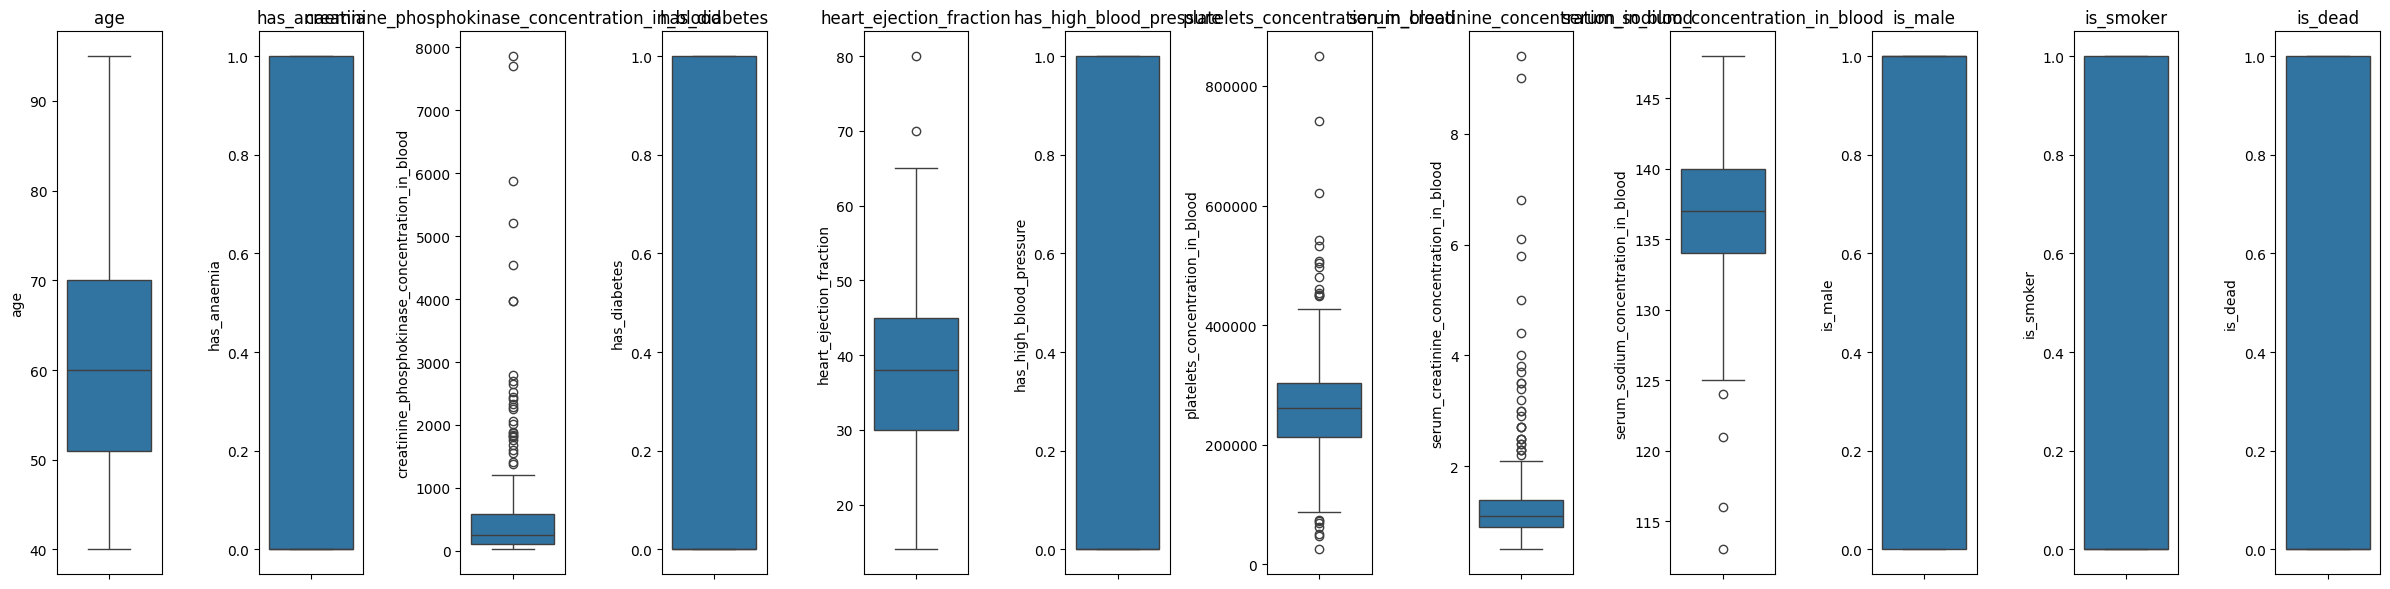

In [ ]:
# BoxPlots to see the range of columns

numeric_cols = df.select_dtypes(include='number').columns

plt.figure(figsize=(max(6, len(numeric_cols)*2), 6))  # Make width flexible based on number of columns

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, len(numeric_cols), i)
    sns.boxplot(y=df[col])
    plt.title(col)
    plt.tight_layout()

plt.show()

In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.33, random_state=42, stratify=df['is_dead'])
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['is_dead'])

In [ ]:
train_df.shape, valid_df.shape, test_df.shape

((200, 12), (49, 12), (50, 12))

In [ ]:
# Normalize Scales for numerical columns

num_cols = ['age', 'creatinine_phosphokinase_concentration_in_blood', 'heart_ejection_fraction',
            'platelets_concentration_in_blood', 'serum_creatinine_concentration_in_blood',
            'serum_sodium_concentration_in_blood']

scaler = RobustScaler()

# Fit scaler on training data ONLY
scaler.fit(train_df[num_cols])

# Transform train_df, valid_df, test_df using same scaler
train_df[num_cols] = scaler.transform(train_df[num_cols])
valid_df[num_cols] = scaler.transform(valid_df[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])

train_df.head()
#valid_df.head()
#test_df.head()

,age,has_anaemia,creatinine_phosphokinase_concentration_in_blood,has_diabetes,heart_ejection_fraction,has_high_blood_pressure,platelets_concentration_in_blood,serum_creatinine_concentration_in_blood,serum_sodium_concentration_in_blood,is_male,is_smoker,is_dead
92,-1.043478,0,0.715517,0,1.466667,0,0.000000,0.20,0.000000,0,0,0
236,0.869565,0,-0.282328,0,0.800000,1,-0.166483,0.00,2.095238,1,0,0
115,-0.115942,1,0.323276,0,0.133333,0,-1.077052,-0.25,0.380952,0,0,0
23,-0.405797,0,-0.403017,1,1.466667,0,1.134330,-0.75,-0.380952,1,0,0
285,-0.289855,1,-0.172414,1,0.133333,0,0.787447,0.25,-0.380952,1,0,0


In [ ]:
def summarize_by_column(train_df, valid_df, test_df):
    print("=== COLUMN-WISE SUMMARY ACROSS SPLITS ===")

    all_cols = train_df.columns

    for col in all_cols:
        print(f"\n→ {col}")
        if pd.api.types.is_numeric_dtype(train_df[col]):
            print(f"  Train : {train_df[col].mean():.2f} ± {train_df[col].std():.2f}")
            print(f"  Valid : {valid_df[col].mean():.2f} ± {valid_df[col].std():.2f}")
            print(f"  Test  : {test_df[col].mean():.2f} ± {test_df[col].std():.2f}")
        else:
            print("  Value Counts (%):")
            print("    Train:")
            print(train_df[col].value_counts(normalize=True).round(3).to_string().replace("\n", "\n      "))
            print("    Valid:")
            print(valid_df[col].value_counts(normalize=True).round(3).to_string().replace("\n", "\n      "))
            print("    Test :")
            print(test_df[col].value_counts(normalize=True).round(3).to_string().replace("\n", "\n      "))

# Run it
summarize_by_column(train_df, valid_df, test_df)

=== COLUMN-WISE SUMMARY ACROSS SPLITS ===

→ age
  Train : 0.06 ± 0.67
  Valid : -0.05 ± 0.67
  Test  : 0.10 ± 0.77

→ has_anaemia
  Train : 0.46 ± 0.50
  Valid : 0.37 ± 0.49
  Test  : 0.38 ± 0.49

→ creatinine_phosphokinase_concentration_in_blood
  Train : 0.77 ± 2.26
  Valid : 0.57 ± 1.29
  Test  : 0.64 ± 2.03

→ has_diabetes
  Train : 0.44 ± 0.50
  Valid : 0.41 ± 0.50
  Test  : 0.34 ± 0.48

→ heart_ejection_fraction
  Train : 0.00 ± 0.81
  Valid : -0.14 ± 0.80
  Test  : 0.17 ± 0.67

→ has_high_blood_pressure
  Train : 0.38 ± 0.49
  Valid : 0.20 ± 0.41
  Test  : 0.40 ± 0.49

→ platelets_concentration_in_blood
  Train : 0.01 ± 1.08
  Valid : -0.24 ± 0.87
  Test  : 0.19 ± 1.11

→ serum_creatinine_concentration_in_blood
  Train : 0.71 ± 2.81
  Valid : 0.96 ± 2.26
  Test  : 0.61 ± 1.86

→ serum_sodium_concentration_in_blood
  Train : -0.03 ± 0.77
  Valid : -0.45 ± 1.12
  Test  : 0.13 ± 0.70

→ is_male
  Train : 0.65 ± 0.48
  Valid : 0.76 ± 0.43
  Test  : 0.54 ± 0.50

→ is_smoker
  Train 

<ipython-input-54-9fc789c4d815>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x="split", y=col, palette="Set2", showmeans=True,


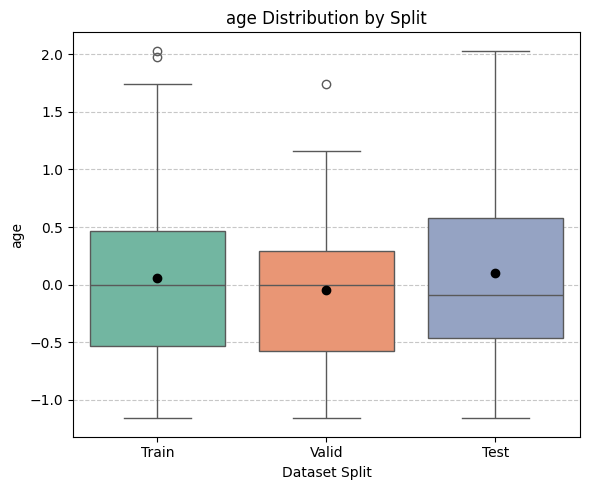

<ipython-input-54-9fc789c4d815>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x="split", y=col, palette="Set2", showmeans=True,


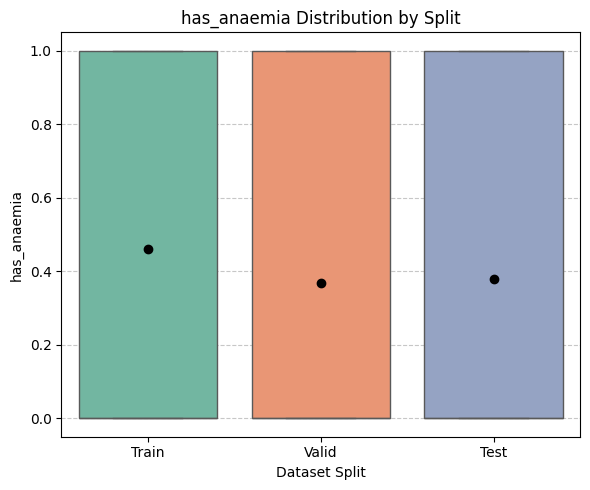

<ipython-input-54-9fc789c4d815>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x="split", y=col, palette="Set2", showmeans=True,


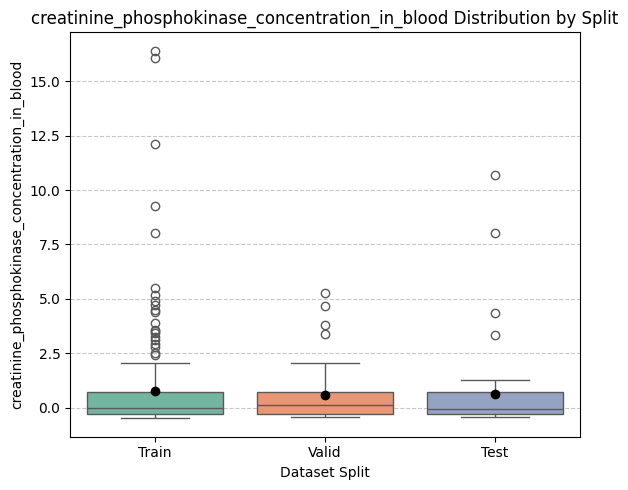

<ipython-input-54-9fc789c4d815>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x="split", y=col, palette="Set2", showmeans=True,


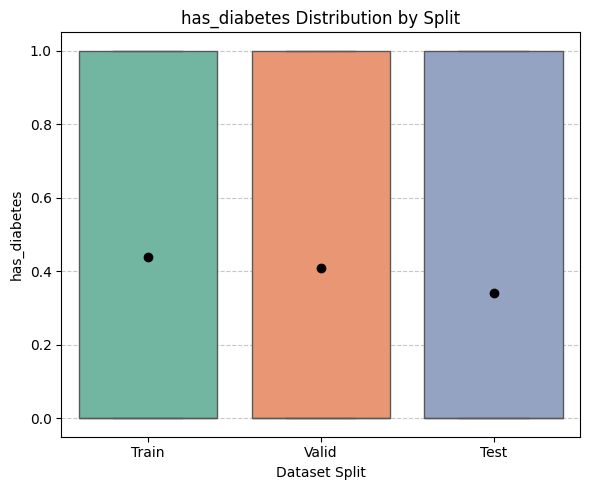

<ipython-input-54-9fc789c4d815>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x="split", y=col, palette="Set2", showmeans=True,


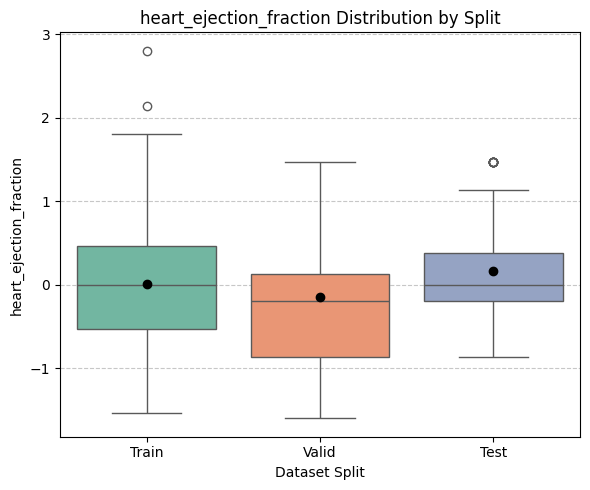

<ipython-input-54-9fc789c4d815>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x="split", y=col, palette="Set2", showmeans=True,


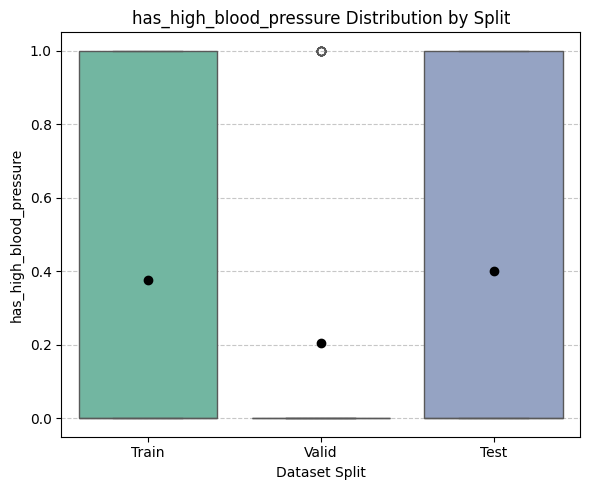

<ipython-input-54-9fc789c4d815>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x="split", y=col, palette="Set2", showmeans=True,


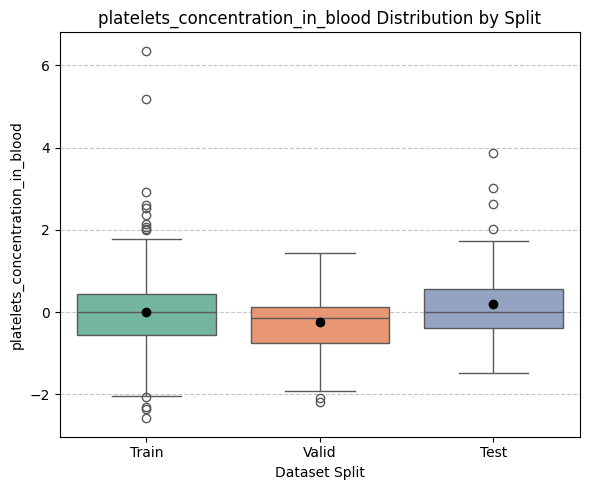

<ipython-input-54-9fc789c4d815>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x="split", y=col, palette="Set2", showmeans=True,


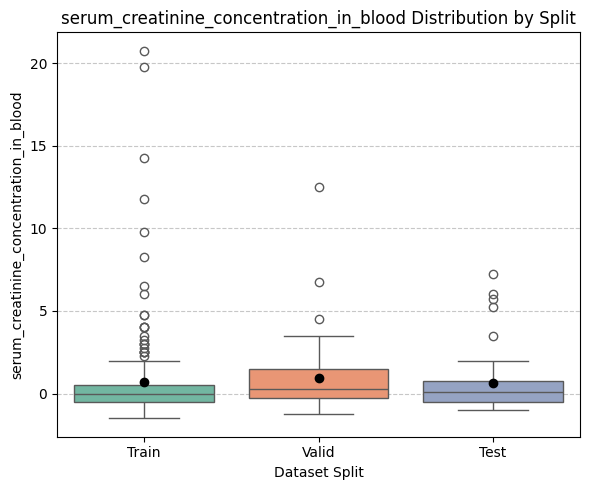

<ipython-input-54-9fc789c4d815>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x="split", y=col, palette="Set2", showmeans=True,


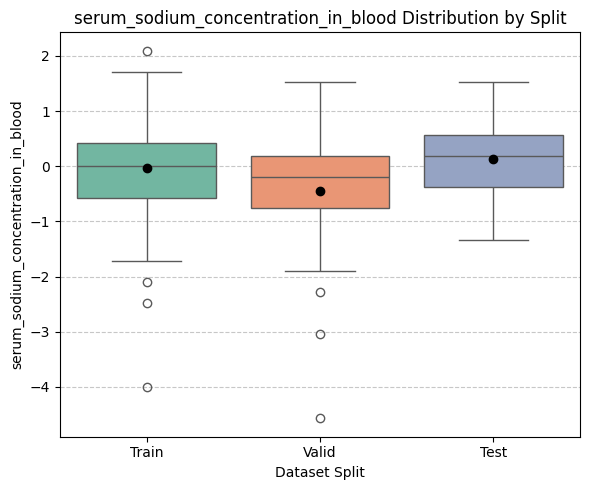

<ipython-input-54-9fc789c4d815>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x="split", y=col, palette="Set2", showmeans=True,


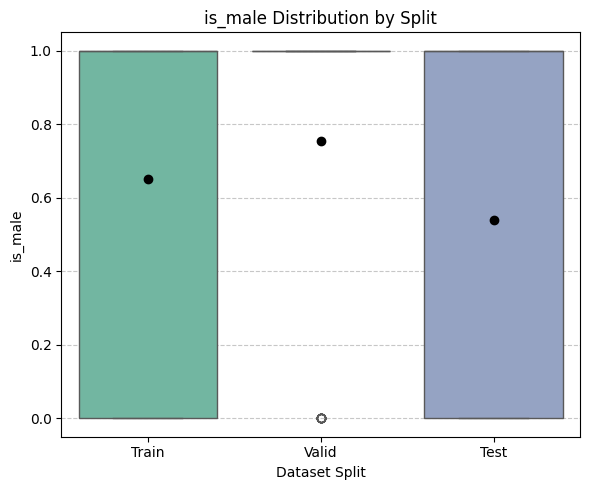

<ipython-input-54-9fc789c4d815>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x="split", y=col, palette="Set2", showmeans=True,


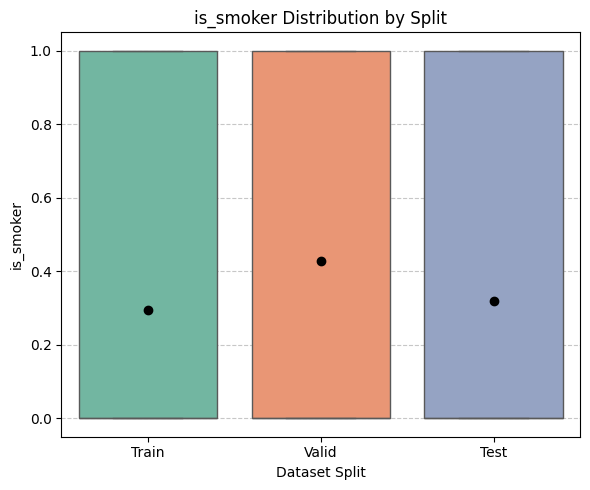

<ipython-input-54-9fc789c4d815>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x="split", y=col, palette="Set2", showmeans=True,


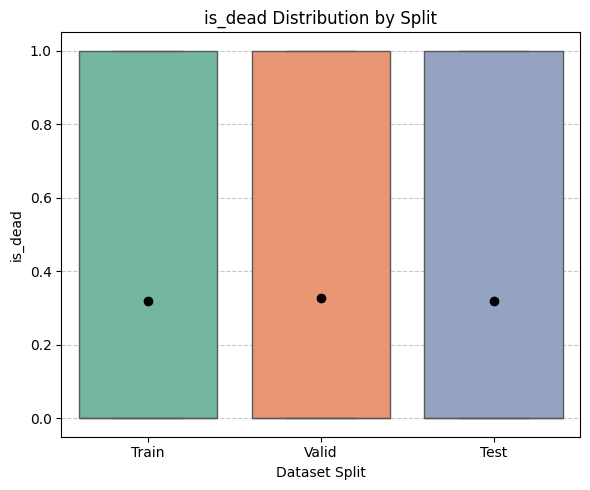

In [ ]:
# Box Plots per column per sets to compare data distributions across sets, necessary to assume any biases

def plot_boxplots(train_df, valid_df, test_df):
    # Add a column indicating which set each row comes from
    train_df = train_df.copy()
    train_df["split"] = "Train"

    valid_df = valid_df.copy()
    valid_df["split"] = "Valid"

    test_df = test_df.copy()
    test_df["split"] = "Test"

    # Combine into one dataframe
    combined_df = pd.concat([train_df, valid_df, test_df])

    numeric_cols = combined_df.select_dtypes(include='number').columns.drop('split', errors='ignore')

    # Plot each numeric column
    for col in numeric_cols:
        plt.figure(figsize=(6, 5))
        sns.boxplot(data=combined_df, x="split", y=col, palette="Set2", showmeans=True,
                    meanprops={"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black"})
        plt.title(f"{col} Distribution by Split")
        plt.xlabel("Dataset Split")
        plt.ylabel(col)
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

plot_boxplots(train_df, valid_df, test_df)

In [ ]:
# Split into features and labels per set

X_train = train_df.drop(columns=['is_dead'])
y_train = train_df['is_dead']

X_valid = valid_df.drop(columns=['is_dead'])
y_valid = valid_df['is_dead']

X_test = test_df.drop(columns=['is_dead'])
y_test = test_df['is_dead']

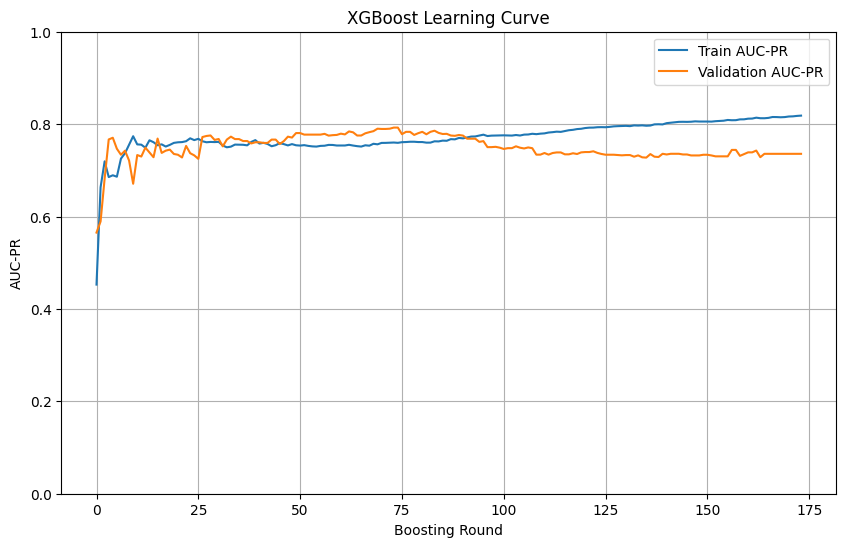

In [ ]:
clf_xgb = xgb.XGBClassifier(seed=30, objective='binary:logistic', gamma=0.25, learning_rate=0.05, max_depth=2, reg_lambda=15, scale_pos_weight=4, subsample=0.9, colsample_bytree=0.5, n_estimators=10000, early_stopping_rounds=100, eval_metric='aucpr')
clf_xgb.fit(X_train, y_train, verbose=False, eval_set=[(X_train, y_train), (X_valid, y_valid)])


bst = clf_xgb.get_booster()
for importance_type in 'weight', 'gain', 'cover', 'total_gain', 'total_cover':
    print(importance_type)
    print(bst.get_score(importance_type=importance_type))

node_params = {'shape': 'box',
               'style': 'filled, rounded',
               'fillcolor': '#78cbe'}

leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size='10,10',
                condition_node_params=node_params,
                leaf_node_params=leaf_params)


evals_result = clf_xgb.evals_result()

#print(evals_result)

train_aucpr = evals_result['validation_0']['aucpr']
valid_aucpr = evals_result['validation_1']['aucpr']

plt.figure(figsize=(10, 6))
plt.plot(train_aucpr, label='Train AUC-PR')
plt.plot(valid_aucpr, label='Validation AUC-PR')
plt.xlabel('Boosting Round')
plt.ylabel('AUC-PR')
plt.ylim(0, 1)
plt.title('XGBoost Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

AUC on train set: 0.8722

              precision    recall  f1-score   support

           0       0.94      0.65      0.77       136
           1       0.55      0.91      0.69        64

    accuracy                           0.73       200
   macro avg       0.74      0.78      0.73       200
weighted avg       0.81      0.73      0.74       200



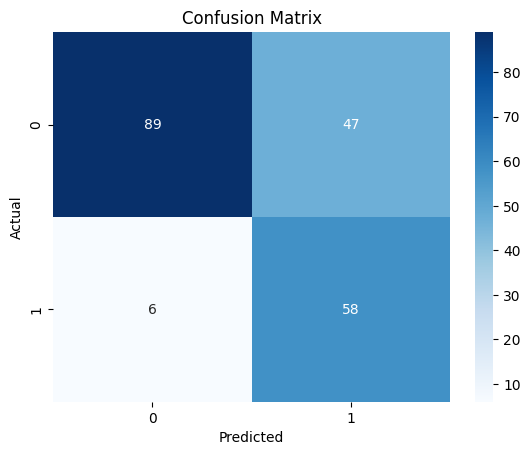

In [ ]:
# train_df performance
y_pred_proba = clf_xgb.predict_proba(X_train)[:, 1]  # Get probability of class 1
y_pred = clf_xgb.predict(X_train)  # Get predicted class labels

auc = roc_auc_score(y_train, y_pred_proba)
print(f"AUC on train set: {auc:.4f}")
print()
print(classification_report(y_train, y_pred))

cm = confusion_matrix(y_train, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

AUC on validation set: 0.8333

              precision    recall  f1-score   support

           0       0.89      0.48      0.63        33
           1       0.45      0.88      0.60        16

    accuracy                           0.61        49
   macro avg       0.67      0.68      0.61        49
weighted avg       0.75      0.61      0.62        49



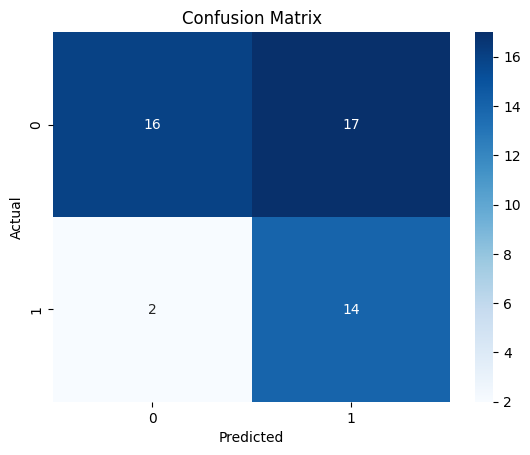

In [ ]:
# valid_df performance
y_pred_proba = clf_xgb.predict_proba(X_valid)[:, 1]  # Get probability of class 1
y_pred = clf_xgb.predict(X_valid)  # Get predicted class labels

auc = roc_auc_score(y_valid, y_pred_proba)
print(f"AUC on validation set: {auc:.4f}")
print()
print(classification_report(y_valid, y_pred))

cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

AUC on test set: 0.8290

              precision    recall  f1-score   support

           0       0.88      0.65      0.75        34
           1       0.52      0.81      0.63        16

    accuracy                           0.70        50
   macro avg       0.70      0.73      0.69        50
weighted avg       0.76      0.70      0.71        50



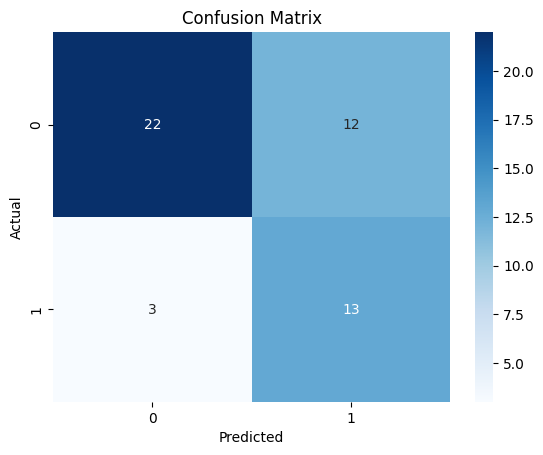

In [ ]:
# Test on test_df
y_pred_proba = clf_xgb.predict_proba(X_test)[:, 1]  # Get probability of class 1
y_pred = clf_xgb.predict(X_test)  # Get predicted class labels

auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC on test set: {auc:.4f}")
print()
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()